# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [3]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

/Users/viggomoro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Bayes classifier functions 

In [2]:
def computePrior(labels, W=None):
    """Computes prior probabilities for every label. W is used to make this probability weighted.
    in: labels - N x 1 vector of class labels      
             W - N x 1 vector of weight for corresponind data points 
    out: prior - C x 1 vector of class priors
    """   
    Npts = labels.shape[0]   
    classes = np.unique(labels)
    Nclasses = np.size(classes)
    
    # Assign weight if not done through input argument
    if W is None:
        W = np.ones((Npts,1))/Npts

    prior = np.zeros((Nclasses,1))   # Preallocate
    # Compute prior for every class. k,c = index_current_class, current_class
    for k,c in enumerate(classes):
        idx = np.where(labels==c)[0]   # Index of current label
        # Weights and labels for current class
        W_current = W[idx]
        labels_current = labels[idx]       
        
        prior_current_class = np.dot(W_current.reshape((np.size(idx),)), np.ones(np.size(labels_current))) # Weighted average 
        prior[k] = prior_current_class

    return prior


def mlParams(X, labels, W=None):
    """Returns the mean vector (mu) and the covariance matrix (sigma) for the maximum likliehood estimation of 
    the paramters. Row j in mu contains the mean for class j and matrix k contains the covariance matrix for 
    class k. It's assuemd that all off-diagonal element in sigma is zero. W is used when data points are to be 
    weighted differently.
    in:      X - N x d matrix of N data points
        labels - N vector of class labels
    out:    mu - C x d matrix of class means (mu[i] - class i mean)
         sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
    """
    Npts, Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # Compute mu. k,c = class_index, class
    for k,c in enumerate(classes):
        idx = np.where(labels==c)[0]  # Find index of the data points with label c     
        # Pick out current data points and weights
        x_current_class = X[idx,:]
        W_current = W[idx]    
        # Calculate mu
        mu_curent_class = np.sum((x_current_class * W_current.reshape((np.size(idx),1))), axis=0) / np.sum(W_current)
        mu[k,:] = mu_curent_class  # Assign to matrix containing mu for every class
    
    # Compute covariance matrix. It's assumed that the off diagonal elements are zero
    for k,c in enumerate(classes):
        idx = np.where(labels==c)[0]
        x_current_class = X[idx,:]
        W_current = W[idx]  #.reshape((np.size(idx),))
        
        difference_squared = np.square(x_current_class - mu[k,:])
        weighted_difference_squared = W_current.reshape(len(idx),1) * difference_squared
        variance_diagonal = np.sum(weighted_difference_squared, axis=0) / np.sum(W_current)
        sigma[k,:,:] = np.diag(variance_diagonal)

    return mu, sigma


def classifyBayes(X, prior, mu, sigma):
    """Computes the log posterior probability and assigns classification according to maximum posteror 
    probability among the different classes for a new data points.
    in:      X - N x d matrix of M data points
         prior - C x 1 matrix of class priors
            mu - C x d matrix of class means (mu[i] - class i mean)
         sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
    out:     h - N vector of class predictions for test points"""
    Npts = X.shape[0]
    Nclasses, Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))   # Compute natural log of posterior probabilities. Element i,j indicate log probability for data point j belonging to class i 
    
    # Determine log posterior probability for every data point and class
    for i, data_point in enumerate(X):
        contrib1 = -0.5 * np.log(np.linalg.det(sigma))   # Contribution from first term in vector form. Row indicates contribution to which class
        
        # Contribution from second term
        contrib2 = np.zeros(Nclasses)
        for k in range(Nclasses):
            contrib2_k = -0.5 * (data_point - mu[k,:]) @ np.linalg.inv(sigma[k,:,:]) @ (data_point - mu[k,:]).T
            contrib2[k] = contrib2_k
        
        contrib3 = np.log(prior).reshape((Nclasses,))  # Contribution from third term
        
        logProb[:,i] = contrib1 + contrib2 + contrib3
    
    # Find maximum in every column i.e for every data point and classify accordingly
    h = np.argmax(logProb,axis=0)
    return h

## Assignmnet 1, Maximum Likelihood estimates

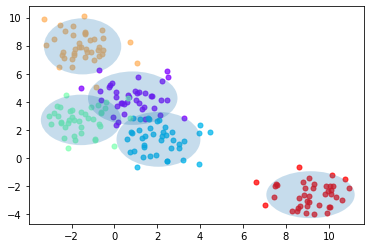

In [4]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

## BayesClassifier

The implemented functions can now be summarized into the `BayesClassifier` class. It will be used to test the classifier

In [5]:
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Assignment 3
Call the `testClassifier` and `plotBoundary` functions for this part.

In [6]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [7]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

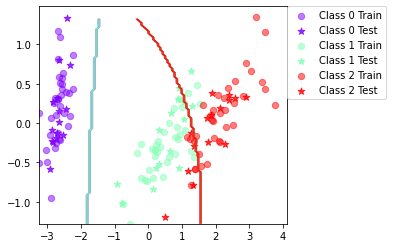

In [8]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

### Answers to questions
1) Få features --> oberoende. Om det finns många features borde de inte vara oberoende  
2) 

## Boosting functions 

In [21]:
def trainBoost(base_classifier, X, labels, T=10):
    """Implementation of the Adaboost algorithm used for boosting classifiers. The weights are updated after 
    each iteration and a new classifiers is trained and then stored.
    
    in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
                      X - N x d matrix of N data points
                 labels - N vector of class labels
                      T - number of boosting iterations
    out:    classifiers - length T Python list of trained classifiers
                 alphas - length T Python list of vote weights"""
    Npts,Ndims = np.shape(X)

    classifiers = []  # append new classifiers to this list
    alphas = []       # append the vote weight of the classifiers to this list
    wCur = np.ones((Npts,1))/float(Npts)   # The weights for the first iteration (all points equally weighted)

    for i_iter in range(0, T):
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))  # train new classifier
        vote = classifiers[-1].classify(X)                                    # do classification for each data point
        
        correct = np.where(vote==labels, 1, 0)                   # Element equal to one if data point is classified correctly and 0 otherwis
        error_t = np.dot(wCur.reshape((Npts,)), 1 - correct)     # Compute error
        alpha_t = 0.5 * (np.log(1 - error_t) - np.log(error_t))  # Calculate alpha
        alphas.append(alpha_t)
        
        # Update the weights
        w_New = wCur.reshape((Npts,)) * np.where(correct==1, np.exp(-alpha_t), np.exp(alpha_t))
        w_New /= np.sum(w_New)    # Normalize
        wCur = w_New
                   
    return classifiers, alphas


def classifyBoost(X, classifiers, alphas, Nclasses):
    """Classifies the instances by means of the aggregated boosted classifier according. The resulting 
    classifications are returned in the vector yPred.
    in:       X - N x d matrix of N data points
    classifiers - (maximum) length T Python list of trained classifiers as above
         alphas - (maximum) length T Python list of vote weights
       Nclasses - the number of different classes
    out:  yPred - N vector of class predictions for test points"""
    
    Npts = X.shape[0]
    Ncomps = len(classifiers)  # Number of different classifiers used for boosting

    # if we only have one classifier we can just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))
    
    available_labels = np.arange(Nclasses).reshape(1,Nclasses)   # Available labels for classification
    
    # Iterate over all classifiers/alphas
    for t in range(Ncomps):
        h_t = classifiers[t].classify(X).reshape(Npts,1)              # Prediction by current classifier
        h_t = np.concatenate([h_t for i in range(Nclasses)], axis=1)  # Turn into matrix with the same 
        delta = np.where(h_t==available_labels,1,0)                   # Matrix with one in element (i,j) if data point i is classified as label j
        contrib_t = alphas[t] * delta
        votes += contrib_t

    # Compute yPred after accumulating the votes
    return np.argmax(votes,axis=1)

## Boosting classifier
The implemented functions can now be summarized as another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. 

In [11]:
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Assignment 5

Call the `testClassifier` and `plotBoundary` functions for this part.

In [12]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6


<ipython-input-10-724cd257e616>:22: RuntimeWarning: divide by zero encountered in log
  alpha_t = 0.5 * (np.log(1 - error_t) - np.log(error_t))  # Calculate alpha
<ipython-input-10-724cd257e616>:27: RuntimeWarning: invalid value encountered in true_divide
  w_New /= np.sum(w_New)    # Normalize
/Users/viggomoro/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
<ipython-input-10-724cd257e616>:57: RuntimeWarning: invalid value encountered in multiply
  contrib_t = alphas[t] * delta


Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.1 with standard deviation 6.72


In [13]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

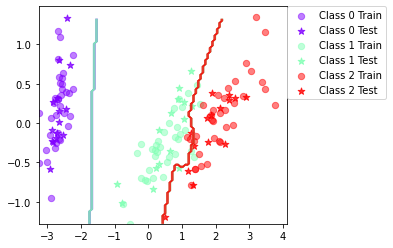

In [14]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

### Answers to questions
1) -    
2) -  
3) -  

## Assignment 6
Now repeat the steps with a decision tree classifier.

In [15]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [16]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [17]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [18]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 86.4
Trial: 10 Accuracy 89.6
Trial: 20 Accuracy 87.7
Trial: 30 Accuracy 92.9
Trial: 40 Accuracy 84.4
Trial: 50 Accuracy 79.9
Trial: 60 Accuracy 88.3
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 88.3
Trial: 90 Accuracy 87
Final mean classification accuracy  86.6 with standard deviation 2.91


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

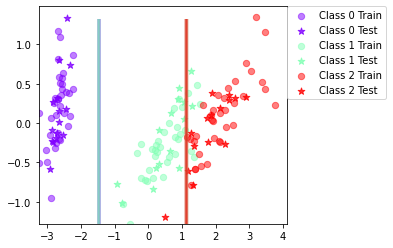

In [19]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

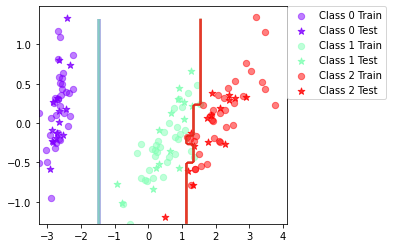

In [20]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Visualize faces classified using boosted decision trees
Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [23]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [24]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 73.3
Trial: 10 Accuracy 76.7
Trial: 20 Accuracy 76.7
Trial: 30 Accuracy 68.3
Trial: 40 Accuracy 74.2
Trial: 50 Accuracy 65.8
Trial: 60 Accuracy 75.8
Trial: 70 Accuracy 72.5
Trial: 80 Accuracy 52.5
Trial: 90 Accuracy 70.8
Final mean classification accuracy  70.7 with standard deviation 7.07


### Classify a face as belonging to one of 40 persons

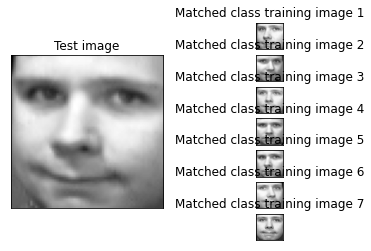

In [27]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti')                # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20)             # use PCA to reduce the dimension to 20
pca.fit(xTr)                                         # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data

# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)

# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])